Preprocessing y visualizacion

In [53]:
import pandas as pd
import os
import numpy as np
import ntpath
from PIL import Image

In [54]:
dir = ""
columns = ["id", "angulo", "imagen", "velocidad"]
data = pd.read_csv(os.path.join(dir, "dataFrameFinalSinAumentar.csv"), names=columns,header=0)
data.head()

,id,angulo,imagen,velocidad
0,1154,30,fotosCarrilHorario2/Img1154.png,450
1,1717,30,fotosCarrilHorario/Img1717.png,450
2,519,30,fotosCarrilAntihorario/Img519.png,450
3,1162,30,fotosCarrilHorario/Img1162.png,450
4,908,30,fotosCarrilHorario2/Img908.png,450


In [12]:
def load_img_steering(dir_img, data_csv):
        image_path = []
        steering = []
        for i in range(len(data_csv)):
            indexed_data = data_csv.iloc[i]
            center= indexed_data[2]
            image_path.append(dir_img +"/"+indexed_data[2])
            steering.append(float(indexed_data[1]))
        image_paths = np.asarray(image_path)
        steerings = np.asarray(steering)
        return image_paths, steerings
dir_img = "fotsCarrilCompleto"
image_paths, angulos = load_img_steering(dir_img, data)
images = np.array([np.array(Image.open(path)) for path in image_paths]) 

MemoryError: Unable to allocate 4.79 GiB for an array with shape (7149, 400, 600, 3) and data type uint8

In [ ]:
#Obteniendo los labels
num_bins = 3
_, bins = np.histogram(data["angulo"], num_bins)

labels=[]
for i in range(len(data["angulo"])):
    for j in range(num_bins):
        if data["angulo"][i] >= bins[j] and data["angulo"][i] <= bins[j + 1]:
            labels.append(j)
            break
labels = np.asarray(labels)

In [ ]:
print(images.shape)

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(0, (15,15))
for i in range(25):
    fig.add_subplot(5,5,i+1)
    plt.imshow(images[i, :, :, :])
    plt.title(str(labels[i])+"°")

**Dataset**

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import os
import pandas as pd
import numpy as np
print(torch.__version__)

c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu116


In [2]:
class NvidiaDataset(torch.utils.data.Dataset):
    def __init__(self, dir_img, dir_csv, transform=None):
        self.dir_img = dir_img
        self.dir_csv = dir_csv
        self.transform = transform
        self.data = self.load_data()

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.data)
    
    def load_data(self):
        data_csv = self.read_csv()
        image_paths, angulos = self.load_img_steering(data_csv)
        
        num_bins = 3
        _, bins = np.histogram(data_csv["angulo"], num_bins)

        labels=[]
        for i in range(len(data_csv["angulo"])):
            for j in range(num_bins):
                if data_csv["angulo"][i] >= bins[j] and data_csv["angulo"][i] <= bins[j + 1]:
                    labels.append(j)
                    break
        labels = np.asarray(labels)
        final_data = [(image_paths[i], labels[i]) for i, label in enumerate(labels)]
        #print(final_data)
        return final_data

    def load_img_steering(self, data_csv):
        image_path = []
        steering = []
        for i in range(len(data_csv)):
            indexed_data = data_csv.iloc[i]
            center= indexed_data[2]
            image_path.append(os.path.join(self.dir_img, center.strip()))
            steering.append(float(indexed_data[1]))
        image_paths = np.asarray(image_path)
        steerings = np.asarray(steering)
        return image_paths, steerings
        
    def read_csv(self):
        columns = ["id", "angulo", "imagen", "velocidad"]
        data = pd.read_csv(self.dir_csv, names=columns,header=0)
        return data
        

*Transforms*

In [3]:
import cv2

class Preprocessing:
    def __init__(self, porcentaje_cropped):
        self.porcentaje = porcentaje_cropped

    def __call__(self, x):
        img_array = np.asarray(x)
        W, H, C = img_array.shape
        img = img_array[int(self.porcentaje*W):,:,:]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img = cv2.GaussianBlur(img, (3, 3), 0)
        img = cv2.resize(img, (128, 128))
        img = img / 255
        return img
class ToFloat32:
    def __call__(self, x):
        return x.to(torch.float32)
transform = transforms.Compose([
    Preprocessing(porcentaje_cropped = 0.4),
    transforms.ToTensor(),
    ToFloat32(),
])

image_dir='fotsCarrilCompleto'
csv_dir='dataFrameFinalSinAumentar.csv'
dataset = NvidiaDataset(image_dir, csv_dir, transform)

**Test-Train split**

In [4]:
from torch.utils.data import random_split, DataLoader
train_size = int(len(dataset)*0.8)
test_size = int(len(dataset))-train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(train_dataset)

**Dataloader**

torch.float32
Shape of x [N, C, H, W]:  torch.Size([32, 3, 128, 128])
Shape of y:  torch.Size([32])


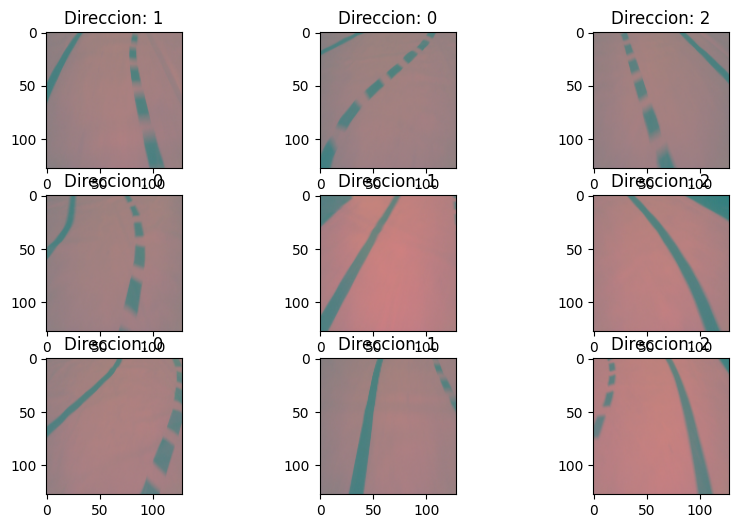

In [5]:
import matplotlib.pyplot as plt
batch_size=32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

fig=plt.figure(0, (10,6))
for x, y in train_dataloader:#Each element x and y (from iterable "test_dataloader") is a batch of 'batch_size' features and labels
    for i in range(9):
        fig.add_subplot(3,3,i+1)
        plt.imshow(np.transpose(x[i], (1, 2, 0)))#COnvertir al formato de matplotlib
        plt.title("Direccion: "+str(int(y[i])))
    print(x[0].dtype)
    print("Shape of x [N, C, H, W]: ",x.shape)#tiene dimensiones 32(batch_size)xC(n_channels)xH(Height)xW(Width)
    print("Shape of y: ",y.shape)#tiene dimensiones 32(batch_size), pues para cada elemento del batch hay un label
    break

**Model**

In [6]:
import torch
from torch import nn
from torch.nn import Flatten, Conv2d, Linear, ReLU, Dropout, MaxPool2d
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('E:/temasc/runs/cnnTraditionalWithoutDataAug')
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else b"cpu"#mps stands for matrix product states, basically enables high-performance training
print("Using: ", device)

Using:  cuda


In [7]:
class nvidiaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.ReLU = ReLU()
        self.conv0 = Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1)
        self.maxPool0 = MaxPool2d(kernel_size=(2, 2), stride=(2 , 2))
        self.conv1 = Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.maxPool1 = MaxPool2d(kernel_size=(2, 2), stride=(2 , 2))
        self.conv2 = Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.maxPool2 = MaxPool2d(kernel_size=(2, 2), stride=(2 , 2))
        self.conv3 = Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)
        self.maxPool3 = MaxPool2d(kernel_size=(2, 2), stride=(2 , 2))
        
        self.fc1 = Linear(in_features=256*8*8, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=3)

    def forward(self, x):
        x = self.ReLU(self.conv0(x))
        x = self.maxPool0(x)
        x = self.ReLU(self.conv1(x))
        x = self.maxPool1(x)
        x = self.ReLU(self.conv2(x))
        x = self.maxPool2(x)
        x = self.ReLU(self.conv3(x))
        x = self.maxPool3(x)
        x = self.flatten(x)
        #FCN
        x = self.ReLU(self.fc1(x))
        logits = self.fc2(x)
        return logits

terrenatorModel = nvidiaModel().to(device)
images, labels = next(iter(train_dataloader))
writer.add_graph(terrenatorModel,images.to("cuda:0"))
writer.close()

**Optim**

In [8]:
loss_fn = nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(terrenatorModel.parameters(), lr=1e-3)

In [9]:

def train(dataloader, model, loss_function, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        x, y = x.to(device), y.to(device)
        #print(x.shape)
        #Calcular el error
        pred = model(x)
        #print(pred, y)
        loss = loss_function(pred, y)
        writer.add_scalar("Loss/train", loss, epoch)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

        if batch % 100 ==0:
            loss, current = loss.item(), batch*len(x)
            print("loss: ", loss, current, size)

In [10]:
def test(dataloader, model, loss_function,t):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('test accuracy', correct*100, t)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, terrenatorModel, loss_fn, optimizer, t)
    test(test_dataloader, terrenatorModel, loss_fn, t)
writer.flush()

Epoch 1
-------------------------------
loss:  1.0961189270019531 0 5719
loss:  0.4888739287853241 3200 5719
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.492693 

Epoch 2
-------------------------------
loss:  0.4674220681190491 0 5719
loss:  0.49435508251190186 3200 5719
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.475429 

Epoch 3
-------------------------------
loss:  0.3790869116783142 0 5719
loss:  0.335178405046463 3200 5719
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.447209 

Epoch 4
-------------------------------
loss:  0.8113070726394653 0 5719
loss:  0.5442457795143127 3200 5719
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.442303 

Epoch 5
-------------------------------
loss:  0.5129545331001282 0 5719
loss:  0.3944832980632782 3200 5719
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.463352 

Epoch 6
-------------------------------
loss:  0.5527288317680359 0 5719
loss:  0.5729238390922546 3200 5719
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.424541 

Epoch 7
--------------------------

In [12]:
torch.save(terrenatorModel, "modelCNNTraditional.pth")

In [43]:
modelo = torch.load("modelCNNTraditional.pth")
modelo.eval()
img = transform(Image.open("Img14.png"))
with torch.no_grad():
    output = modelo(img.unsqueeze(0).to("cuda:0"))
    _, predicted = torch.max(output.data, 1)
    print(predicted.item())


0


In [ ]:
torch.save(terrenatorModel.state_dict(), "modelTerrenator.pth")

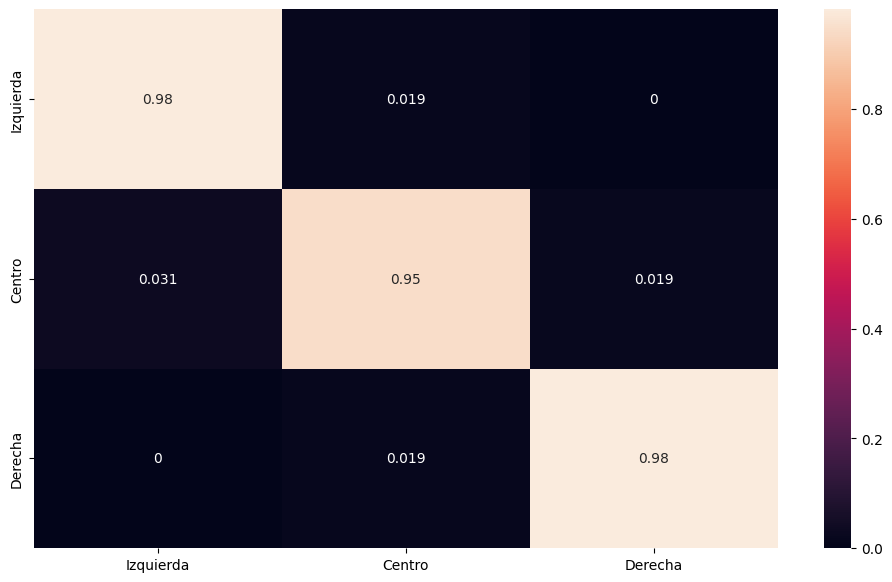

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = modelo(inputs.to("cuda:0")) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Izquierda', 'Centro', 'Derecha')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')